In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.interpolate as spi
import scipy.sparse as sp
import scipy.linalg as sla
from scipy.sparse.linalg import inv
from scipy.sparse.linalg import spsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False

np.random.seed(1031)
dt_hex = '#2B4750'    # dark teal,  RGB = 43,71,80
r_hex = '#DC2624'     # red,        RGB = 220,38,36
g_hex = '#649E7D'     # green,      RGB = 100,158,125
tl_hex = '#45A0A2'    # teal,       RGB = 69,160,162
tn_hex = '#C89F91'    # tan,        RGB = 200,159,145

## <font color='blue' face='微软雅黑'>欧式期权回顾</font>

在 **BS** 模型下，原生资产 (以股票价格为例) 的随机微分方程如下：

<br/>
<font color='blue'>
\begin{equation}
\frac{dS(t)}{S(t)} = (r-q)dt+\sigma dW(t)
\end{equation}
</font>
    
其中

- $S(t)$ = 资产在时点 $t$ 的值
- $r$ = 常数型瞬时利率
- $q$ = 常数型瞬时红利率
- $\sigma$ = 常数型瞬时波动率
- $W(t)$ = 布朗运动

根据 **BS** 公式，欧式期权的解析解为

<br/>
<font color='blue'>
\begin{equation}
\begin{aligned}
V = e^{-rT} \cdot E\left[ \left[ \omega\left(S_T-K\right)\right]^+\right]
= \omega\cdot\left[e^{-qT}S_0\Phi(\omega\cdot d_+) - e^{-rT}K\Phi(\omega\cdot d_{-})\right] 
\end{aligned}
\end{equation}
</font>
    
其中

<br/>
<font color='blue'>
\begin{equation}
d_{\pm} = \frac{1}{\sigma\sqrt{T}}\ln\left(\frac{S_0e^{(r-q)T}}{K}\right)\pm\frac{\sigma\sqrt{T}}{2}
\end{equation}
</font>

看涨期权对应 $\omega = 1$，看跌期权对应 $\omega = -1$。

In [2]:
def blackscholes( S0=100, K=100, r=0.01, q=0.01, T=1, sigma=0.2, omega=1 ):
    discount = np.exp(-r*T)
    forward = S0*np.exp((r-q)*T)
    moneyness = np.log(forward/K)
    vol_sqrt_T = sigma*np.sqrt(T)
    
    d1 = moneyness / vol_sqrt_T + 0.5*vol_sqrt_T
    d2 = d1 - vol_sqrt_T
    
    V = omega * discount * (forward*norm.cdf(omega*d1) - K*norm.cdf(omega*d2))
    return V

考虑一个看跌期权，假设股价 S = 50，行权价格 K = 60，利率为 3%，红利率为 1%，期限为 1 年，波动率为 40%，它的特征如下表所示：

| 属性      | 符号        |值 |
|-----------|:------------:|:---:|
| 股票价格 | $S$          |50 |
| 行权价格 | $K$        |60 |
| 连续利率  | $r$        |3% |
| 连续红利率  | $q$        |1% |
| 波动率  | $\sigma$        |40% |
| 到期年限  | $T$        |1 |

带入写好的 `blackscholes` 函数来计算期权的价值。

In [3]:
(S0, K, r, q, T, sigma, omega) = (50, 60, 0.03, 0.01, 1, 0.4, -1)
blackscholes(S0, K, r, q, T, sigma, omega)

13.583200733417277

### <font color='black' face='微软雅黑'>有限差分</font>

In [5]:
(S, K, r, q, T, sigma, option_type) = (50, 60, 0.03, 0.01, 1, 0.4, 'put')
(Smin, Smax, Ns, Nt) = (0, 4*np.maximum(S,K), 200, 200)

In [6]:
class OptionPricingMethod():
    
    def __init__(self, S, K, r, q, T, sigma, option_type):
        self.S = S
        self.K = K
        self.r = r
        self.q = q
        self.T = T
        self.sigma = sigma
        self.option_type = option_type
        self.is_call = (option_type[0].lower()=='c')
        self.omega = 1 if self.is_call else -1

In [7]:
class FiniteDifference(OptionPricingMethod):
    
    def __init__(self, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt):
        super().__init__(S, K, r, q, T, sigma, option_type)
        self.Smin = Smin
        self.Smax = Smax
        self.Ns = int(Ns)
        self.Nt = int(Nt)
        self.dS = (Smax-Smin)/Ns * 1.0
        self.dt = T/Nt*1.0
        self.Svec = np.linspace(Smin, Smax, self.Ns+1)
        self.Tvec = np.linspace(0, T, self.Nt+1)
        self.grid = np.zeros(shape=(self.Ns+1, self.Nt+1))
        
    def _set_terminal_condition_(self):
        self.grid[:, -1] = np.maximum(self.omega*(self.Svec - self.K), 0)
    
    def _set_boundary_condition_(self):
        tau = self.Tvec[-1] - self.Tvec;     
        DFq = np.exp(-q*tau)
        DFr = np.exp(-r*tau)

        self.grid[0,  :] = np.maximum(self.omega*(self.Svec[0]*DFq - self.K*DFr), 0)
        self.grid[-1, :] = np.maximum(self.omega*(self.Svec[-1]*DFq - self.K*DFr), 0)        
        
    def _set_coefficient__(self):
        drift = (self.r-self.q)*self.Svec[1:-1]/self.dS
        diffusion_square = (self.sigma*self.Svec[1:-1]/self.dS)**2
        
        self.l = 0.5*(diffusion_square - drift)
        self.c = -diffusion_square - self.r
        self.u = 0.5*(diffusion_square + drift)
        
    def _solve_(self):
        pass
    
    def _interpolate_(self):
        tck = spi.splrep( self.Svec, self.grid[:,0], k=3 )
        return spi.splev( self.S, tck )
        #return np.interp(self.S, self.Svec, self.grid[:,0])
    
    def price(self):
        self._set_terminal_condition_()
        self._set_boundary_condition_()
        self._set_coefficient__()
        self._set_matrix_()
        self._solve_()
        return self._interpolate_()

### <font color='black' face='微软雅黑'>完全显式法</font>

In [8]:
class FullyExplicitEu(FiniteDifference):
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M = self.I + self.dt*self.A
                                        
    def _solve_(self):
        for j in reversed(np.arange(self.Nt)):
            U = self.M.dot(self.grid[1:-1, j+1])
            U[0] += self.l[0]*self.dt*self.grid[0, j+1] 
            U[-1] += self.u[-1]*self.dt*self.grid[-1, j+1] 
            self.grid[1:-1, j] = U

### <font color='black' face='微软雅黑'>完全隐式法</font>

In [9]:
class FullyImplicitEu(FiniteDifference):

    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M = self.I - self.dt*self.A
    
    def _solve_(self):  
        _, M_lower, M_upper = sla.lu(self.M.toarray())

        for j in reversed(np.arange(self.Nt)):      
            U = self.grid[1:-1, j+1].copy()
            U[0] += self.l[0]*self.dt*self.grid[0, j] 
            U[-1] += self.u[-1]*self.dt*self.grid[-1, j] 
            Ux = sla.solve_triangular( M_lower, U, lower=True )
            self.grid[1:-1, j] = sla.solve_triangular( M_upper, Ux, lower=False )

### <font color='black' face='微软雅黑'>克兰克尼克尔森法 </font>

In [10]:
class CrankNicolsonEu(FiniteDifference):

    theta = 0.5
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M1 = self.I + (1-self.theta)*self.dt*self.A
        self.M2 = self.I - self.theta*self.dt*self.A
    
    def _solve_(self):           
        _, M_lower, M_upper = sla.lu(self.M2.toarray())        
        for j in reversed(np.arange(self.Nt)):
            
            U = self.M1.dot(self.grid[1:-1, j+1])
            
            U[0] += self.theta*self.l[0]*self.dt*self.grid[0, j] \
                 + (1-self.theta)*self.l[0]*self.dt*self.grid[0, j+1] 
            U[-1] += self.theta*self.u[-1]*self.dt*self.grid[-1, j] \
                  + (1-self.theta)*self.u[-1]*self.dt*self.grid[-1, j+1] 
            
            Ux = sla.solve_triangular( M_lower, U, lower=True )
            self.grid[1:-1, j] = sla.solve_triangular( M_upper, Ux, lower=False )

## <font color='blue' face='微软雅黑'>美式期权</font>
### <font color='black' face='微软雅黑'>迭代法</font>

In [29]:
class SOR(FiniteDifference):

    def __init__(self, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon):
        super().__init__(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt)
        self.theta = theta
        self.alpha = alpha
        self.epsilon = epsilon
        self.max_iter = 10*Nt
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M1 = self.I + (1-self.theta)*self.dt*self.A
    
    def _solve_(self):           
        w = self.alpha
        thedt = self.theta * self.dt
        payoff = self.grid[1:-1, -1]
        m = len(payoff)
        pastval = payoff.copy()
        
        for j in reversed(np.arange(self.Nt)):
            counter = 0
            noBreak = 1
            newval = pastval.copy()
            
            z = self.M1.dot(pastval)
            
            z[0] += self.theta*self.l[0]*self.dt*self.grid[0, j] \
                 + (1-self.theta)*self.l[0]*self.dt*self.grid[0, j+1] 
            z[-1] += self.theta*self.u[-1]*self.dt*self.grid[-1, j] \
                  + (1-self.theta)*self.u[-1]*self.dt*self.grid[-1, j+1] 
            
            while noBreak:
                counter += 1
                oldval = newval.copy()
                newval[0] = np.maximum( payoff[0], oldval[0] + w/(1-thedt*self.c[0]) \
                                       *( z[0] - (1-thedt*self.c[0])*oldval[0] \
                                         + thedt*self.u[0]*oldval[1]) )
                for k in np.arange(1,m-1):
                    newval[k] = np.maximum( payoff[k], oldval[k] + w/(1-thedt*self.c[k]) \
                                           *( z[k] + thedt*self.l[k]*newval[k-1] \
                                             - (1-thedt*self.c[k])*oldval[k] \
                                             + thedt*self.u[k]*oldval[k+1]) )
        
                newval[m-1] = np.maximum( payoff[m-1], oldval[m-1] + w/(1-thedt*self.c[m-1]) \
                                         *( z[m-1] + thedt*self.l[m-1]*newval[m-2] \
                                           - (1-thedt*self.c[m-1])*oldval[m-1]) )
        
                noBreak = SOR.trigger( oldval, newval, self.epsilon, counter, self.max_iter )
                
            pastval = newval.copy()
            self.grid[1:-1, j] = pastval
      
    @staticmethod
    def trigger( oldval, newval, tol, counter, maxIteration ):
        noBreak = 1
        if np.max( np.abs(newval-oldval)/np.maximum(1,np.abs(newval)) ) <= tol:
            noBreak = 0
        elif counter > maxIteration:
            print('结果可能不收敛。')
            noBreak = 0
        return noBreak

In [16]:
(theta, alpha, epsilon) = (0.5, 1.5, 1e-6)
amer_opt = SOR(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon)
print(amer_opt.price())

13.83873807149034


### <font color='black' face='微软雅黑'>惩罚法</font>

In [17]:
class PM(FiniteDifference):

    def __init__(self, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon):
        super().__init__(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt)
        self.theta = theta
        self.lbd = lbd
        self.epsilon = epsilon
        self.max_iter = 10*Nt
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1], format='csc')
        self.I = sp.eye(self.Ns-1)
    
    def _solve_(self):           
        (theta, dt) = (self.theta, self.dt)
        payoff = self.grid[1:-1, -1]
        pastval = payoff.copy()
        G = payoff.copy()
        
        for j in reversed(np.arange(self.Nt)):
            counter = 0
            noBreak = 1
            newval = pastval.copy()
            
            while noBreak:
                counter += 1
                oldval = newval.copy()
                D = sp.diags( (G > (1-theta)*pastval + theta*newval).astype(int), format='csc' )
                z = (self.I + (1-theta)*dt*(self.A - self.lbd*D))*pastval + dt*self.lbd*D*G
                
                z[0] += theta*self.l[0]*dt*self.grid[0, j] \
                 + (1-theta)*self.l[0]*dt*self.grid[0, j+1] 
                z[-1] += theta*self.u[-1]*dt*self.grid[-1, j] \
                  + (1-theta)*self.u[-1]*dt*self.grid[-1, j+1] 
                                
                M = self.I - theta*dt*(self.A - self.lbd*D)
                newval = spsolve(M,z)
        
                noBreak = PM.trigger( oldval, newval, self.epsilon, counter, self.max_iter )
            
            pastval = newval.copy()
            self.grid[1:-1, j] = pastval
    
    @staticmethod
    def trigger( oldval, newval, tol, counter, maxIteration ):
        noBreak = 1
        if np.max( np.abs(newval-oldval)/np.maximum(1,np.abs(newval)) ) <= tol:
            noBreak = 0
        elif counter > maxIteration:
            print('结果可能不收敛。')
            noBreak = 0
        return noBreak

In [18]:
(theta, lbd, epsilon) = (0.5, 1e6, 1e-6)
amer_opt = PM(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon)
print(amer_opt.price())

13.838720062454613


## <font color='blue' face='微软雅黑'>百慕大期权</font>
### <font color='black' face='微软雅黑'>迭代法</font>

In [19]:
class SOR_bermudan(SOR):

    def __init__(self, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon, ex_tvec):
        super().__init__(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon)
        self.ex_tvec = ex_tvec
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M1 = self.I + (1-self.theta)*self.dt*self.A
        self.M2 = self.I - self.theta*self.dt*self.A
    
    def _solve_(self):           
        w = self.alpha
        thedt = self.theta * self.dt
        payoff = self.grid[1:-1, -1]
        m = len(payoff)
        pastval = payoff.copy()

        idx = SOR_bermudan.get_idx( self.Tvec, self.ex_tvec )
        _, M_lower, M_upper = sla.lu(self.M2.toarray())  
        
        for j in reversed(np.arange(self.Nt)):
            z = self.M1.dot(pastval)

            z[0] += self.theta*self.l[0]*self.dt*self.grid[0, j] \
                 + (1-self.theta)*self.l[0]*self.dt*self.grid[0, j+1] 
            z[-1] += self.theta*self.u[-1]*self.dt*self.grid[-1, j] \
                  + (1-self.theta)*self.u[-1]*self.dt*self.grid[-1, j+1] 
            
            if j in idx: # update V = max(V, payoff)
                counter = 0
                noBreak = 1
                newval = pastval.copy()

                while noBreak:
                    counter += 1
                    oldval = newval.copy()
                    newval[0] = np.maximum( payoff[0], oldval[0] + w/(1-thedt*self.c[0]) \
                                           *( z[0] - (1-thedt*self.c[0])*oldval[0] \
                                             + thedt*self.u[0]*oldval[1]) )
                    for k in np.arange(1,m-1):
                        newval[k] = np.maximum( payoff[k], oldval[k] + w/(1-thedt*self.c[k]) \
                                               *( z[k] + thedt*self.l[k]*newval[k-1] \
                                                 - (1-thedt*self.c[k])*oldval[k] \
                                                 + thedt*self.u[k]*oldval[k+1]) )

                    newval[m-1] = np.maximum( payoff[m-1], oldval[m-1] + w/(1-thedt*self.c[m-1]) \
                                             *( z[m-1] + thedt*self.l[m-1]*newval[m-2] \
                                               - (1-thedt*self.c[m-1])*oldval[m-1]) )

                    noBreak = SOR_bermudan.trigger( oldval, newval, self.epsilon, counter, self.max_iter )

                pastval = newval.copy()
                
            else: # solve normal PDE            
                Ux = sla.solve_triangular( M_lower, z, lower=True )
                pastval = sla.solve_triangular( M_upper, Ux, lower=False )
            
            self.grid[1:-1, j] = pastval

                
    def get_tvec( tvec, ex_tvec ):
        all_tvec = np.unique( np.sort( np.concatenate([tvec,ex_tvec]) ) )
        return all_tvec
    
    def get_idx( tvec, ex_tvec ):
        all_tvec = SOR_bermudan.get_tvec( tvec, ex_tvec )
        return np.array( [np.where(all_tvec==t)[0][0] for t in ex_tvec] )

In [20]:
ex_tvec1 = np.arange(0.5, 1, 0.5)        # 每六个月可执行权利
ex_tvec2 = np.arange(0.25, 1, 0.25)      # 每三个月可执行权利
ex_tvec3 = np.arange(1/12, 1, 1/12)      # 每一个月可执行权利

berm_opt1 = SOR_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon, ex_tvec1)
berm_opt2 = SOR_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon, ex_tvec2)
berm_opt3 = SOR_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon, ex_tvec3)
amer_opt = SOR(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, alpha, epsilon)

opt = np.array( [berm_opt1.price(), berm_opt2.price(), berm_opt3.price(), amer_opt.price()] )

print( f'每六个月可执行权利的百慕大期权价值为 {opt[0]}' )
print( f'每三个月可执行权利的百慕大期权价值为 {opt[1]}' )
print( f'每一个月可执行权利的百慕大期权价值为 {opt[2]}' )
print( f'美式期权价值为 {opt[3]}' )

每六个月可执行权利的百慕大期权价值为 13.717249229884288
每三个月可执行权利的百慕大期权价值为 13.775377430417794
每一个月可执行权利的百慕大期权价值为 13.818423314217622
美式期权价值为 13.83873807149034


随着可执行日的增加，百慕大期权价值越大，最终收敛于美式期权，结果是合理的。

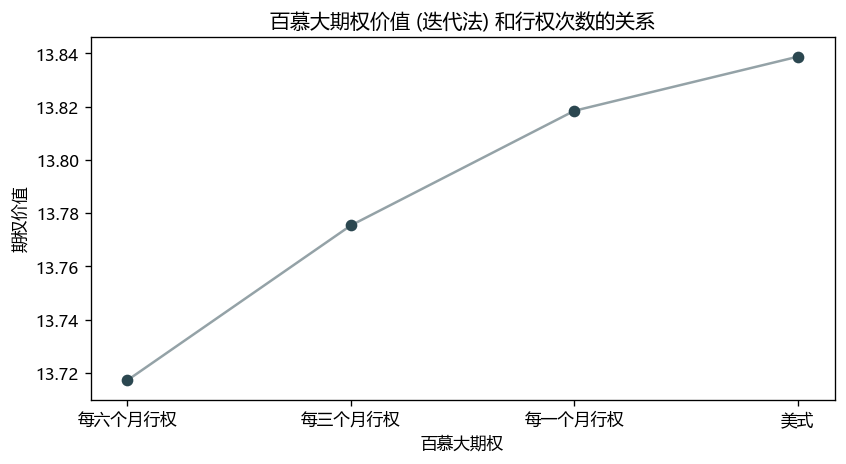

In [21]:
fig = plt.figure(figsize=(8,4), dpi=120)
ax = fig.gca()

X = np.arange(len(opt))

ax.plot( X, opt, color=dt_hex, alpha=0.5)
ax.scatter( X, opt, color =dt_hex )

ax.set_xticks(X)
ax.set_xticklabels(['每六个月行权', '每三个月行权', '每一个月行权', '美式' ])
ax.set_xlabel('百慕大期权')
ax.set_ylabel('期权价值')
ax.set_title('百慕大期权价值 (迭代法) 和行权次数的关系')
plt.show()

### <font color='black' face='微软雅黑'>惩罚法</font>

In [22]:
class PM_bermudan(PM):
    
    def __init__(self, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon, ex_tvec):
        super().__init__(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon)
        self.ex_tvec = ex_tvec
    
    def _set_matrix_(self):
        self.A = sp.diags([self.l[1:], self.c, self.u[:-1]], [-1, 0, 1],  format='csc')
        self.I = sp.eye(self.Ns-1)
        self.M1 = self.I + (1-self.theta)*self.dt*self.A
        self.M2 = self.I - self.theta*self.dt*self.A
        
    
    def _solve_(self):           
        (theta, dt) = (self.theta, self.dt)
        payoff = self.grid[1:-1, -1]
        pastval = payoff.copy()
        G = payoff.copy()
        
        idx = PM_bermudan.get_idx( self.Tvec, self.ex_tvec )
        _, M_lower, M_upper = sla.lu(self.M2.toarray())  
        
        for j in reversed(np.arange(self.Nt)):
            if j in idx: # update V = max(V, payoff)
                counter = 0
                noBreak = 1
                newval = pastval.copy()

                while noBreak:
                    counter += 1
                    oldval = newval.copy()
                    D = sp.diags( (G > (1-theta)*pastval + theta*newval).astype(int), format='csc' )
                    z = (self.I + (1-theta)*dt*(self.A - self.lbd*D))*pastval + dt*self.lbd*D*G

                    z[0] += theta*self.l[0]*dt*self.grid[0, j] \
                         + (1-theta)*self.l[0]*dt*self.grid[0, j+1] 
                    z[-1] += theta*self.u[-1]*dt*self.grid[-1, j] \
                          + (1-theta)*self.u[-1]*dt*self.grid[-1, j+1] 

                    M = self.I - theta*dt*(self.A - self.lbd*D)
                    newval = spsolve(M, z)

                    noBreak = PM.trigger( oldval, newval, self.epsilon, counter, self.max_iter )

                pastval = newval.copy()
                
            else: # solve normal PDE
                z = self.M1.dot(pastval)

                z[0] += theta*self.l[0]*dt*self.grid[0, j] \
                     + (1-theta)*self.l[0]*dt*self.grid[0, j+1] 
                z[-1] += theta*self.u[-1]*dt*self.grid[-1, j] \
                      + (1-theta)*self.u[-1]*dt*self.grid[-1, j+1] 
                
                Ux = sla.solve_triangular( M_lower, z, lower=True )
                pastval = sla.solve_triangular( M_upper, Ux, lower=False )
            
            self.grid[1:-1, j] = pastval
    
    
    def get_tvec( tvec, ex_tvec ):
        all_tvec = np.unique( np.sort( np.concatenate([tvec,ex_tvec]) ) )
        return all_tvec
    
    def get_idx( tvec, ex_tvec ):
        all_tvec = SOR_bermudan.get_tvec( tvec, ex_tvec )
        return np.array( [np.where(all_tvec==t)[0][0] for t in ex_tvec] )

In [23]:
berm_opt1 = PM_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon, ex_tvec1)
berm_opt2 = PM_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon, ex_tvec2)
berm_opt3 = PM_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon, ex_tvec3)
amer_opt = PM(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon)

opt = np.array( [berm_opt1.price(), berm_opt2.price(), berm_opt3.price(), amer_opt.price()] )

print( f'每六个月可执行权利的百慕大期权价值为 {opt[0]}' )
print( f'每三个月可执行权利的百慕大期权价值为 {opt[1]}' )
print( f'每一个月可执行权利的百慕大期权价值为 {opt[2]}' )
print( f'美式期权价值为 {opt[3]}' )

每六个月可执行权利的百慕大期权价值为 13.853390090245725
每三个月可执行权利的百慕大期权价值为 13.845273020995345
每一个月可执行权利的百慕大期权价值为 13.840369733518726
美式期权价值为 13.838720062454613


随着可执行日的增加，百慕大期权价值越小，结果是**不合理**的。

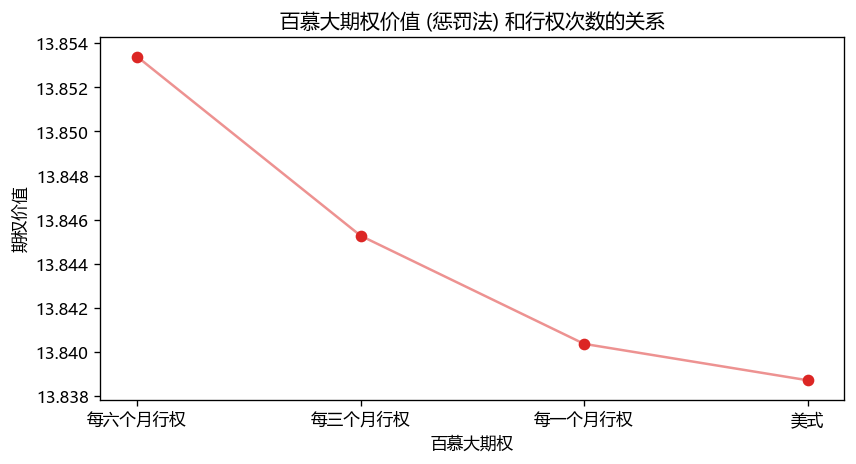

In [24]:
fig = plt.figure(figsize=(8,4), dpi=120)
ax = fig.gca()

X = np.arange(len(opt))

ax.plot( X, opt, color=r_hex, alpha=0.5)
ax.scatter( X, opt, color=r_hex )

ax.set_xticks(X)
ax.set_xticklabels(['每六个月行权', '每三个月行权', '每一个月行权', '美式' ])
ax.set_xlabel('百慕大期权')
ax.set_ylabel('期权价值')
ax.set_title('百慕大期权价值 (惩罚法) 和行权次数的关系')
plt.show()

为了检查代码的逻辑错误，我们用两个极端情况：

- 没有执行日，`ex_tvec = []`，这时百慕大期权就是个欧式期权
- 可连续执行，`ex_tvec = np.linspace(0, T, Nt+1)`，这时百慕大期权就是个美式期权

In [25]:
ex_tvec = []
berm_opt1 = PM_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon, ex_tvec)
euro_opt = CrankNicolsonEu(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt)

ex_tvec = np.linspace(0, T, Nt+1)
berm_opt2 = PM_bermudan(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon, ex_tvec)
amer_opt = PM(S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, theta, lbd, epsilon)

print( f'没有执行权利的百慕大期权价值为 {berm_opt1.price()}；欧式期权价值为 {euro_opt.price()}' )
print( f'连续执行权利的百慕大期权价值为 {berm_opt2.price()}；美式期权价值为 {amer_opt.price()}' )

没有执行权利的百慕大期权价值为 13.580616848408745；欧式期权价值为 13.580616848408745
连续执行权利的百慕大期权价值为 13.838720062454613；美式期权价值为 13.838720062454613


极限情况的结果完全正确，侧面证明 `PM_bermudan()` 代码在单独处理**美式**和**欧式**期权定价部分都没有错，保险起见，我们用 `SOR_bermudan()` 来对百慕大期权进行定价。 

### <font color='blue' face='微软雅黑'>有限差分收敛检验</font>

In [26]:
def convergence_test( func, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns_vec, Nt_vec, *PDE_para ):
    numerical = np.array([])
    for Ns, Nt in zip(Ns_vec, Nt_vec):
        option = func( S, K, r, q, T, sigma, option_type, Smin, Smax, Ns, Nt, *PDE_para )
        numerical = np.append(numerical, option.price())
    
    error = np.diff(numerical)
    return error, numerical

In [27]:
Ns_vec = np.array([100, 200, 400, 800])
Nt_vec = np.array([200, 400, 800, 1600])
errorSOR, priceSOR = convergence_test( SOR, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns_vec, Nt_vec, theta, alpha, epsilon )
errorPM, pricePM = convergence_test( PM, S, K, r, q, T, sigma, option_type, Smin, Smax, Ns_vec, Nt_vec, theta, lbd, epsilon )

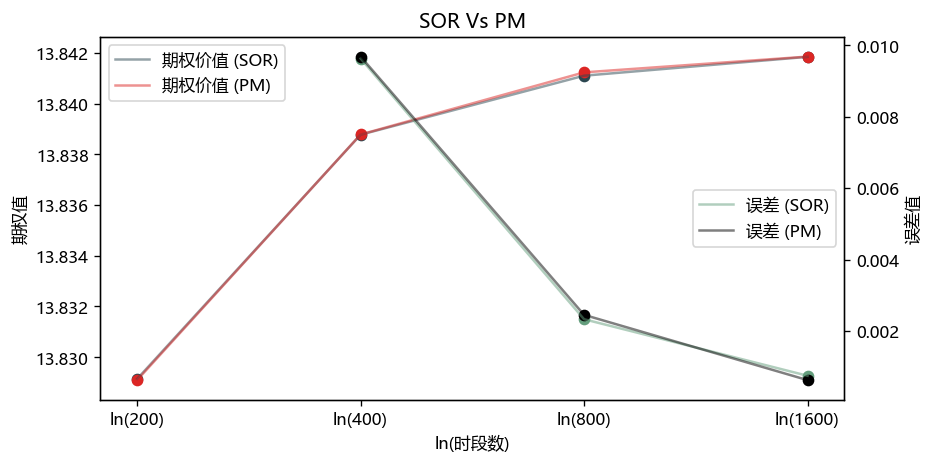

In [28]:
fig = plt.figure(figsize=(8,4), dpi=120)
ax1 = fig.gca()

X1 = np.log(Nt_vec)
ax1.plot( X1, priceSOR, color=dt_hex, alpha=0.5, label='期权价值 (SOR)' )
ax1.scatter( X1, priceSOR, color=dt_hex )
ax1.plot( X1, pricePM, color=r_hex, alpha=0.5, label='期权价值 (PM)' )
ax1.scatter( X1, pricePM, color=r_hex )

ax1.set_xticks(np.log(Nt_vec))
ax1.set_xticklabels(['ln(200)', 'ln(400)', 'ln(800)', 'ln(1600)'])
ax1.set_xlabel('ln(时段数)')
ax1.set_ylabel('期权值')
ax1.set_title('SOR Vs PM')
ax1.legend()

ax2 = ax1.twinx()
X2 = X1[1:]
ax2.plot( X2, errorSOR, color=g_hex, alpha=0.5, label='误差 (SOR)' )
ax2.scatter( X2, errorSOR, color=g_hex )
ax2.plot( X2, errorPM, color='black', alpha=0.5, label='误差 (PM)' )
ax2.scatter( X2, errorPM, color='black' )
ax2.set_ylabel('误差值')
ax2.legend(loc='center right')

plt.show()